# GWP - Submission #2

# Q1

Using a simple Fourier pricing technique (using 𝑁 = 100 intervals, and using an effective
upper bound of integration of 30), price a vanilla call option assuming that the underlying
share follows the Heston model dynamics. Use the parameter values from the previous
section (GWP #1), as well as the following parameter values:
• 𝑣_0 = 0.06
• κ = 9
• θ = 0.06
• 𝜌 = −0.4

In [5]:
from scipy.stats import norm
import math
import random
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
from scipy.stats import ncx2

In [4]:
# Share specific  information
r = 0.08 #risk free rate
S0 = 100 #Current stock price
sigma = 0.3 #volatility of the underlying share is 30%
sigma_cp = 0.25 # volatility for the counterparty firm value
cp_debt = 175 # counterparty debt, due in one year
corel = 0.2 # correlation between the counterparty and the stock.
reco = 0.25 #recovery rate with the counterparty

# Call Option specific information
K = 100 #strike
T = 1
k_log = np.log(K)

#Hestom model parameters
v0 = 0.06
kappa = 9
theta = 0.06
rho = -0.4

#Approximation information
t_max = 30
N = 100


In [5]:
#Characterristic function code

a = sigma**2/2

def b(u): 
    return kappa - rho*sigma*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return (b(u)+d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val1

def D(u):
    val1 = 1-np.exp(-T*d(u))
    val2 = 1-g(u)*np.exp(-T*d(u))
    return (val1/val2)*xminus(u)

def log_char(u):
    return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S0))

def adj_char(u):
    return log_char(u-1j)/log_char(-1j)


In [6]:
#Price of call

delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

#Integral calculations
first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

fourier_call_val = S0*(1/2 + first_integral/np.pi)-np.exp(-r*T)*K*(1/2 + second_integral/np.pi)
fourier_call_val

13.734895692109063

# Q2 

We will now simulate a share price path. Assume that $\sigma\left(t_{i}, t_{i+1}\right)=\sigma\left(S_{t i}\right)^{\gamma-1}$, where $\sigma=$ $0.3$ and $\gamma=0.75$. Using the formula below, simulate paths for the underlying share using sample sizes of $1000,2000, \ldots, 50000 .$ Perform monthly simulations for a period of a year. We can simulate the next step in a share price path using the following formula:
$$
S_{t_{i+1}}=S_{t_{i}} e^{\left(r-\frac{\sigma^{2}\left(t_{i}, t_{i+1}\right)}{2}\right)\left(t_{i+1}-t_{i}\right)+\sigma\left(t_{i}, t_{i+1}\right) \sqrt{t_{i+1}-t_{i}} Z}
$$
where $S_{t i}$ is the share price at time $t_{i}, \sigma\left(t_{i}, t_{i+1}\right)$ is the volatility for the period $\left[t_{i}, t_{i+1}\right], r$ is the risk-free interest rate, and $Z \sim N(0,1)$.

Note that we are attempting to run simulations using the CEV model. However, while the CEV model assumes that volatility is a continuous function of time and share price, we are making a simplifying assumption that volatility is constant over each simulation period.

In [7]:
# Variable declaration

gamma = 0.75
n_sim = 1000  # number of simulation


In [8]:
def CEV(sigma,K,gamma):
    return sigma*(K**(gamma-1))

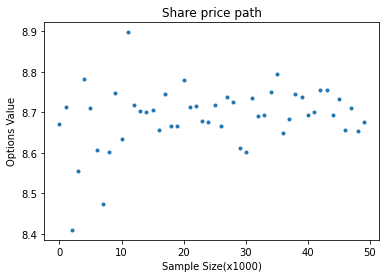

In [15]:
def euro_call(S0,K,T,r,sigma,n_sim,gamma):
    n_step = 12 # number of steps - monthly
    dt = T/n_step 
    total=0
    vol_est = sigma*(K**(gamma-1))  # CEV model for volatitily estimation
    
    for p in range(0,n_sim):
        S_t=S0
        
        for q in range(0,int(n_step)):
            random.seed(0)
            Z = scipy.random.normal()
            S_t*=np.exp((r-0.5*vol_est**2)*dt + vol_est*Z*np.sqrt(dt))
            
        total+=np.exp(-r*T)*(np.maximum(S_t-K,0))
    return total/n_sim


random.seed(0)
options_path=[None]*50
for i in range(1,51):
    options_path[i-1]=euro_call(S0,K,T,r,sigma,n_sim*i,gamma)


plt.plot(options_path,".")
plt.xlabel("Sample Size(x1000)")
plt.ylabel("Options Value")
plt.title("Share price path")
plt.show()

# Q3

Augment your code in part 2 to calculate Monte Carlo estimates, as well as the standard deviations for these estimates, for the price of a vanilla call option (with the same strike term as in Submission 1).

In [13]:
# Call price under CEV
z = 2 + 1/(1-gamma)

def analytical_Call(t,K):
    kappa = 2*r/(sigma**2*(1-gamma)*(np.exp(2*r*(1-gamma)*t)-1))
    x = kappa*S0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S0*(1-ncx2.cdf(y,z,x))-K*np.exp(-r*t)*ncx2.cdf(x,z-2,y)

analytical_call_price = analytical_Call(T,K)
print("Analytical call price", analytical_call_price)

Analytical call price 8.702333534327622


# Q4 

Plot the Monte Carlo estimates generated in part 3 with respect to sample size, as well as three standard deviation error bounds around these estimates.

In [22]:
np.random.seed(0)

def euro_call(S0, sigma, T, gamma, n_sim):
    n_step= 12 
    dt = T/n_step
    call= np.zeros([n_sim], dtype=float)
    for j in range(0,n_sim):
        sT=S0
        sigmaT = sigma
        for i in range(0,int(n_step)):
            e = np.random.normal()
            sigmaT = sigma*sT**(gamma - 1)
            sT = sT*np.exp((r-0.5*sigmaT**2)*dt+sigmaT*e*np.sqrt(dt))
        call[j] = max(sT-K,0)

    call_price = np.mean(call*np.exp(-r*T))
    call_std = np.std(call*np.exp(-r*T))/np.sqrt(n_sim)
    return call_price, call_std

In [23]:
# Generating analytical estimates for call as a function of sample size

mcall_estimates = [None]*50
mcall_std = [None]*50

for i in range(1,51):
    mcall_estimates[i-1], mcall_std[i-1]  = euro_call(S0, sigma, T, gamma, i*1000)

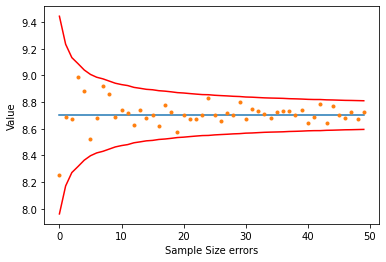

In [24]:
# Plotting the monte carlo estimates against the sample size and std errors
plt.plot([analytical_call_price]*50)
plt.plot(mcall_estimates, '.')
plt.xlabel("Sample Size errors")
plt.ylabel("Value")
plt.plot(analytical_call_price+np.array(mcall_std)*3,'r')
plt.plot(analytical_call_price-np.array(mcall_std)*3,'r')

plt.show()

# Q5 

Graph the volatility smile (2 pts)

• Visit https://finance.yahoo.com/quote/FB/options/
    
• Find the strike closest to the current price of Facebook stock (take whatever
maturity/ies you’d like). Call this K. Find its volatility. Call this sigma

• Then find the 3 closest strikes below K. Find their implied volatilities from the website.

• Then find the 3 closest strikes above K. Find their implied volatilities from the website.

• Graph the strikes along the x-axis, and the implied volatilities along the y-axis.

• Label this graph the “Facebook Option Volatility Smile”.


In [1]:
import pandas as pd

k = 350
sigma = 0.2626

low_strike1 = 342.5
sigma_lk1 = 0.2625

low_strike2 = 345
sigma_lk2 = 0.2466

low_strike3 = 347.5
sigma_lk3 = 0.2427

high_strike1 = 352.5
sigma_hk1 = 0.2315

high_strike2 = 355
sigma_hk2 = 0.2272

high_strike3 = 357.5
sigma_hk3 = 0.2269

In [ ]:
dataset = [[low_strike1, sigma_lk1], [low_strike2, sigma_lk2], [low_strike3, sigma_lk3], [k, sigma], [high_strike1, sigma_hk1], [high_strike2, sigma_hk2], [high_strike3, sigma_hk3]]
 
df = pd.DataFrame(dataset, columns = ['Strike', 'Implied Volatility'])
df.plot.line(x = 'Strike', y = 'Implied Volatility', title = "Facebook Option Volatility Smile")

# Q7

The volatility skewness is defined as the change in implied volatility (delta y) divided by the change in strike level (delta x). Using the strikes below K, calculate the volatility skew for Facebook. 

In [11]:
sigma_skewlk1 = (k-low_strike1)/ (sigma*100 - sigma_lk1*100)


sigma_skewlk2 = (k-low_strike2)/ (sigma*100 - sigma_lk2*100)


sigma_skewlk3 = (k-low_strike3)/ (sigma*100 - sigma_lk3*100)


print(sigma_skewlk1)
print(sigma_skewlk2)
print(sigma_skewlk3) 

749.9999999998828
3.1249999999999973
1.2562814070351747
